Scores of different techniques for coyo-1k-TEXT dataset:

| Comparison      | PCA          | UMAP         | t-SNE        |
|-----------------|--------------|--------------|--------------|
| Trustworthiness |0.0.999700|  0.999543            | 0.999591            |
| Continuity      |0.999799          | 0.999736           | 0.999751             |
| Cosine Similarity | 7.257074e-07         |0.150968|  0.002865            |
| Linear Translation  | 1.319569e-25      |  22.482631           |  30.238292            |
| Euclidean Correlation |0.999997      |  0.738646          |    0.981130          |
| Geodesic Distance Pres       | 0.572656             | 0.982638            | 0.948360            |



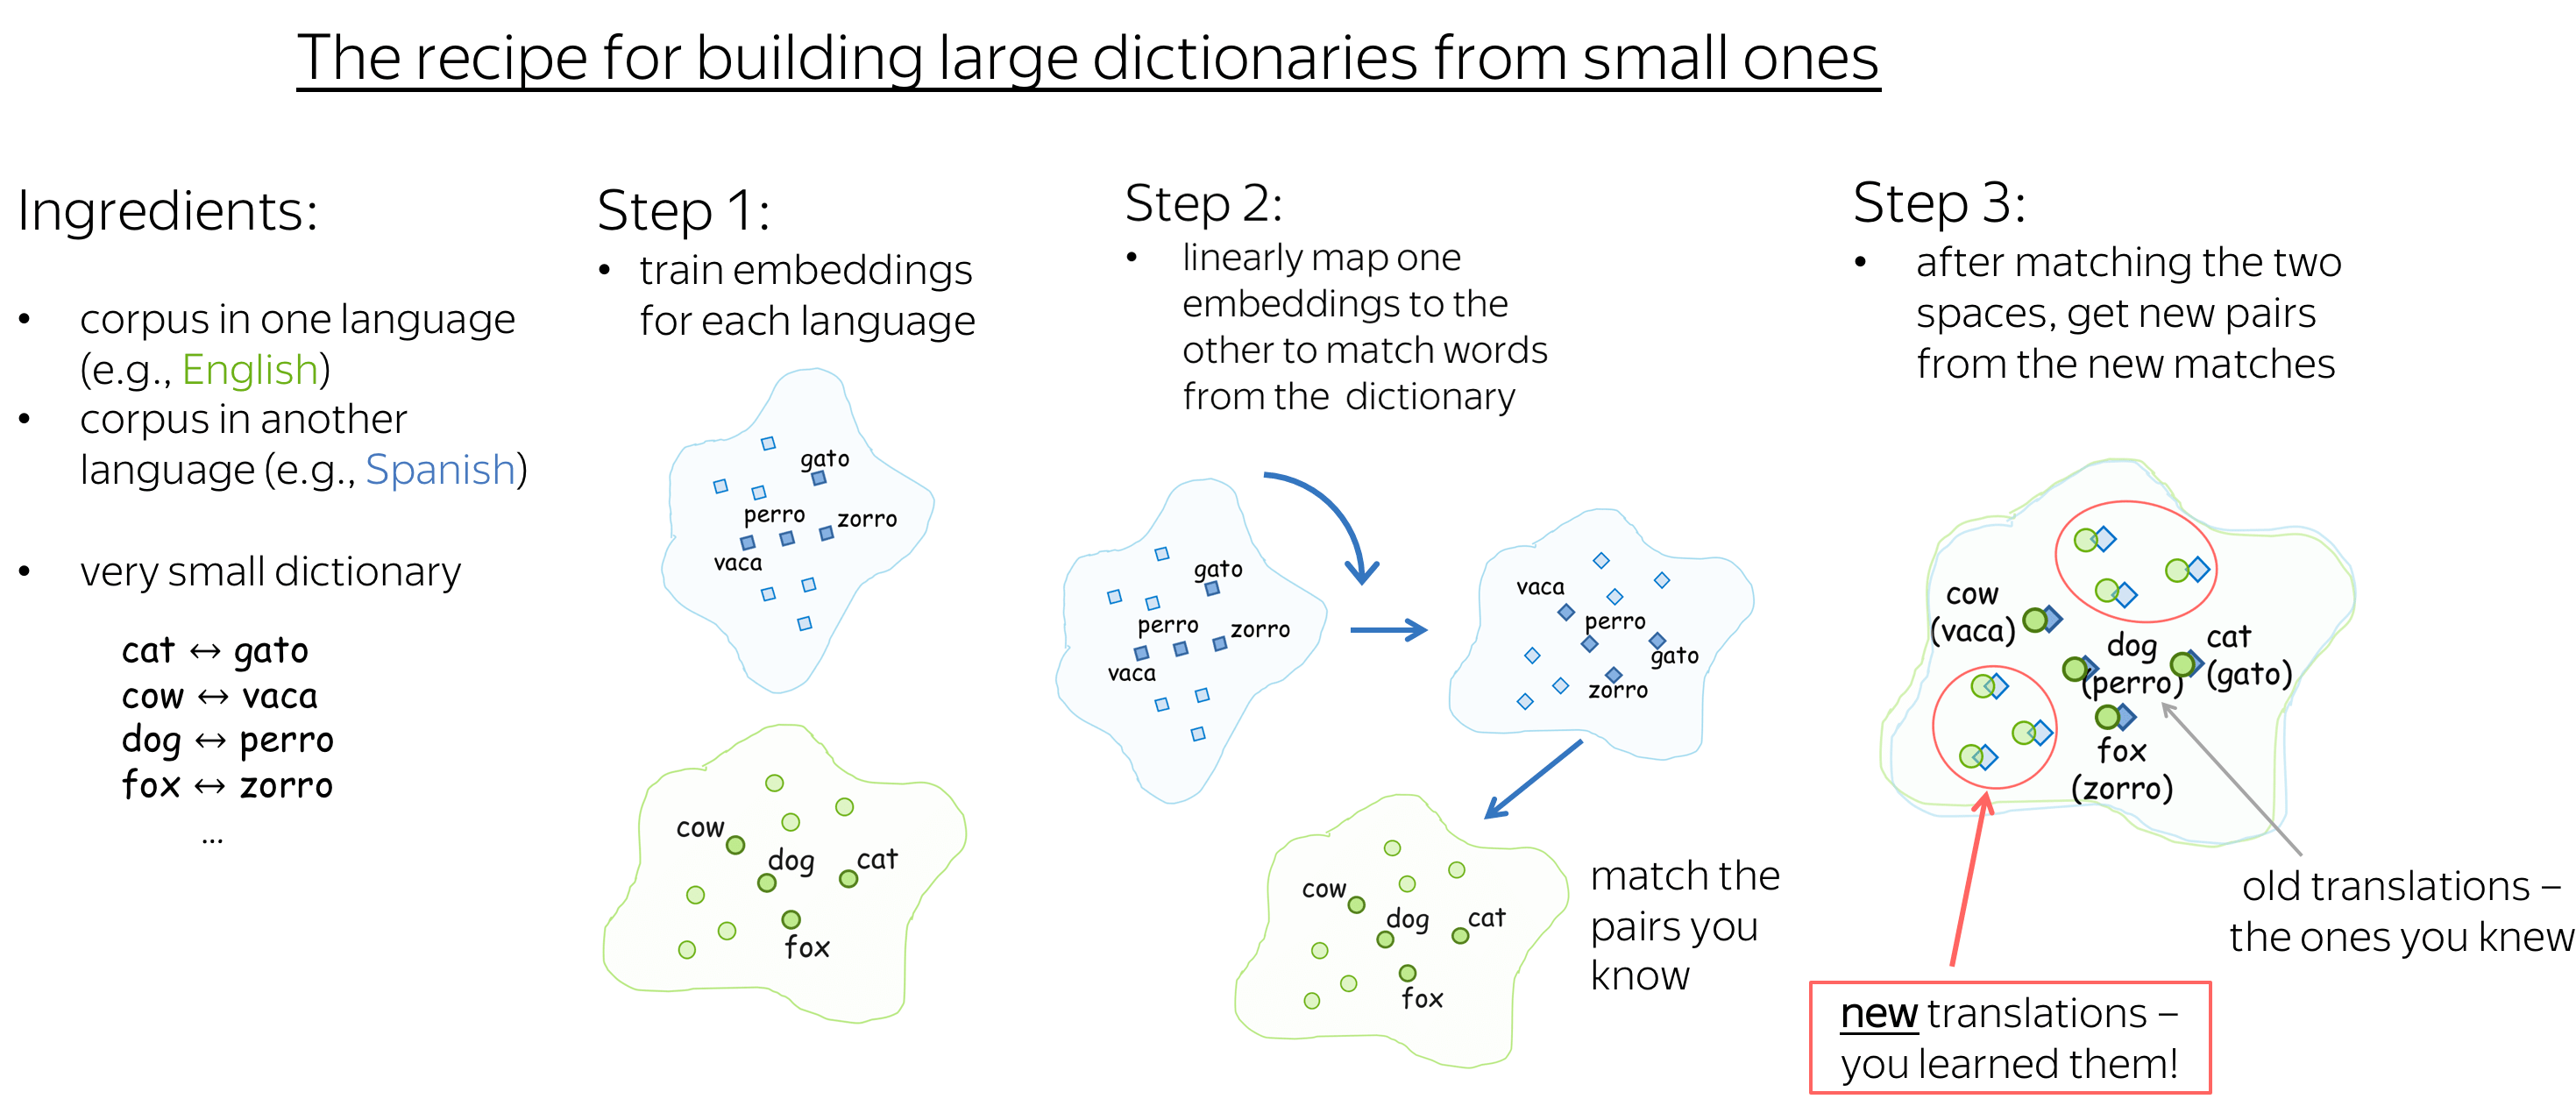

In [22]:
import numpy as np
import pandas as pd
import os
from google.colab import files

In [2]:
uploaded=files.upload()

Saving clip_text_embeddings.csv to clip_text_embeddings (1).csv


In [ ]:
!pip install umap-learn

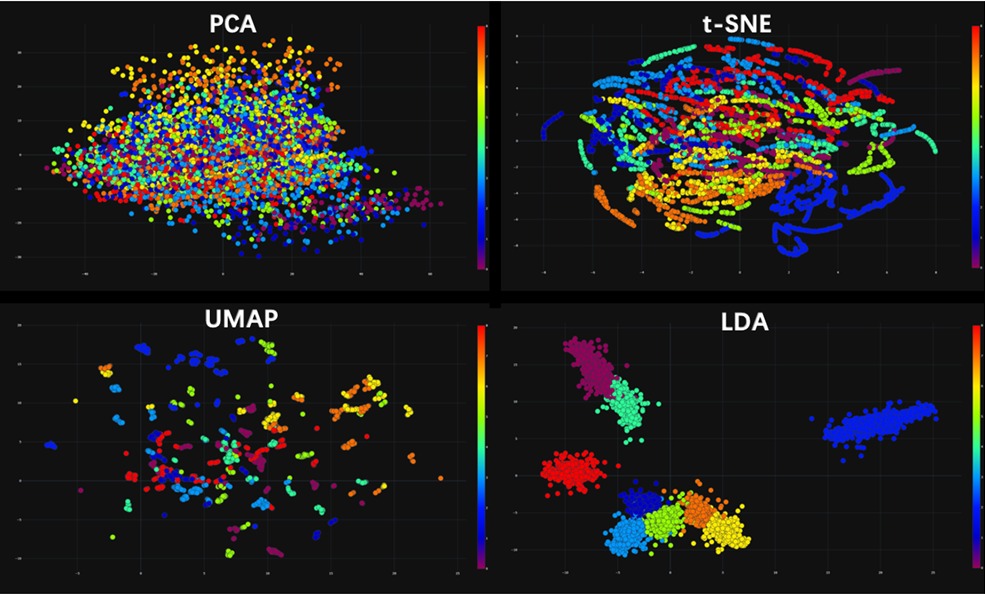

In [24]:
#importing the packages for dim red techniques
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

In [25]:
#metrics for comparing dim red techniques
from sklearn.manifold import trustworthiness
from sklearn.metrics import pairwise_distances

In [26]:
df=pd.read_csv('clip_text_embeddings (1).csv')

In [27]:
X=df.drop(columns=['prompt']).values

In [28]:
#PCA
pca=PCA(n_components=2)
X_pca=pca.fit_transform(X)

In [29]:
#UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
X_umap = umap_model.fit_transform(X)

In [30]:
#t-SNE
tsne=TSNE(n_components=2)
X_tsne=tsne.fit_transform(X)

# Trustworthiness Formula

Trustworthiness measures how well the local neighborhood structure is preserved in the reduced-dimensional space compared to the original space. It is defined as:

$Tk = 1 - \frac{2}{nk(2n-3k-1)} \sum_{i=1}^{n} \sum_{j \in N_k^i} (r_{ij}^X - k)$

Where:

- **n** is the number of data points.
- **k** is the number of nearest neighbors.
- $( r_{ij}^X )$ is the rank of the $ j^{th} $ nearest neighbor of data point i in the original space.
- $( N_k^i $) represents the set of k nearest neighbors of data point i in the original space.


In [31]:
def compute_trustworthiness(X, X_embedded, n_neighbors=5):
    return trustworthiness(X, X_embedded, n_neighbors=n_neighbors)

# Continuity Formula

Continuity measures how well points that are close in the original space remain close in the reduced space. It is defined as:

$C_k = 1 - \frac{2}{nk(2n-3k-1)} \sum_{i=1}^{n} \sum_{j \in V_i} (r_{ij}^Y - k)$

Where:

- **n** is the number of data points.
- **k** is the number of nearest neighbors.
- $ r_{ij}^Y $ is the rank of the $ j^{th}$ nearest neighbor of data point i in the reduced space.
- V_i represents the set of data points in the original space that are nearest neighbors of data point i, but not in the reduced space.


In [32]:
def compute_continuity(X, X_embedded, n_neighbors=5):
    og_dist=pairwise_distances(X)
    emb_dist=pairwise_distances(X_embedded)

    n_samples = X.shape[0]

    #rank of each data pt's nearest neighbour in the og space and embedded space
    rank_og=np.argsort(np.argsort(og_dist,axis=1), axis=1)
    rank_emb=np.argsort(np.argsort(emb_dist,axis=1), axis=1)

    continuity_score = 0.0

    for i in range(n_samples):
        #indices of nearest neighbours in original space and embedded space
        original_neighbors=np.argsort(og_dist[i])[:n_neighbors]
        embedded_neighbors=np.argsort(emb_dist[i])[:n_neighbors]

        diff=np.setdiff1d(original_neighbors, embedded_neighbors)

        #updates continuity score based on rank diff
        for j in diff:
            continuity_score += (rank_emb[i, j] - n_neighbors)

    continuity_score = 1 - (2.0 / (n_samples * n_neighbors * (2 * n_samples - 3 * n_neighbors - 1))) * continuity_score

  #continuity score generated here is based on the same formula as above, except it is normalised to a range between 0 and 1.
    return continuity_score

In [33]:
trust_pca = compute_trustworthiness(X, X_pca)
cont_pca = compute_continuity(X, X_pca)
print(f"PCA Trustworthiness: {trust_pca}, Continuity: {cont_pca}")

PCA Trustworthiness: 0.9997002016129032, Continuity: 0.9997993951612903


In [34]:
trust_umap = compute_trustworthiness(X, X_umap)
cont_umap = compute_continuity(X, X_umap)
print(f"UMAP Trustworthiness: {trust_umap}, Continuity: {cont_umap}")

UMAP Trustworthiness: 0.9995350806451613, Continuity: 0.9997336693548388


In [35]:
trust_tsne = compute_trustworthiness(X, X_tsne)
cont_tsne = compute_continuity(X, X_tsne)
print(f"t-SNE Trustworthiness: {trust_tsne}, Continuity: {cont_tsne}")

t-SNE Trustworthiness: 0.9995895161290322, Continuity: 0.9997514112903226


# Geodesic Distance Preservation Formula

Geodesic distance preservation measures how well the geodesic distances (shortest path distances along the manifold) are preserved in the reduced-dimensional space compared to the original space. It is defined as:

$
\text{Stress} = \sum_{i=1}^{n} \sum_{j=1}^{n} (d_{ij} - \hat{d}_{ij})^2
$

$
\text{Original Sum} = \sum_{i=1}^{n} \sum_{j=1}^{n} d_{ij}^2
$

$
\text{Geodesic Distance Preservation} = \sqrt{\frac{\text{Stress}}{\text{Original Sum}}}
$

Where:
- n is the number of data points.
- $d_{ij}$ is the geodesic distance (shortest path distance) between data points i and j in the original space.
- $\hat{d}_{ij}$ is the distance between data points i and j in the reduced-dimensional space.


In [36]:
from sklearn.manifold import Isomap
def compute_geodesic_distances(X, n_neighbors=5):
    isomap = Isomap(n_neighbors=n_neighbors, n_components=2)
    isomap.fit(X)
    geodesic_distances = isomap.dist_matrix_
    return geodesic_distances

def compute_gdp(X, X_embedded, n_neighbors=5):
    geodesic_distances = compute_geodesic_distances(X, n_neighbors=n_neighbors)
    embedded_distances = pairwise_distances(X_embedded)

    stress = np.sum((geodesic_distances - embedded_distances)**2)
    original_sum = np.sum(geodesic_distances**2)

    return np.sqrt(stress / original_sum)

gdp_pca=compute_gdp(X, X_pca)
gdp_umap=compute_gdp(X, X_umap)
gdp_tsne=compute_gdp(X, X_tsne)

print(f"Geodesic Distance Preservation PCA: {gdp_pca}")
print(f"Geodesic Distance Preservation UMAP: {gdp_umap}")
print(f"Geodesic Distance Preservation t-SNE: {gdp_tsne}")

Geodesic Distance Preservation PCA: 0.572656858579319
Geodesic Distance Preservation UMAP: 0.9818469594281053
Geodesic Distance Preservation t-SNE: 0.9482586561883276


In [37]:
max_trustworthiness = max(trust_pca, trust_umap, trust_tsne)
max_continuity = max(cont_pca, cont_umap, cont_tsne)
min_gdp=min(gdp_pca, gdp_umap, gdp_tsne)

print(f"Max Trustworthiness: {max_trustworthiness}")
print(f"Max Continuity: {max_continuity}")
print(f"Best Geodesic Distance Preservation: {min_gdp}")

Max Trustworthiness: 0.9997002016129032
Max Continuity: 0.9997993951612903
Best Geodesic Distance Preservation: 0.572656858579319


trustworthiness for local structure preservation, **higher** the score better the preservation; ranges from 0 to 1


continuity for global structure preservation by embeddings, **higher** the score better the preservation; ranges from 0 to 1


gdp specifically focuses on preserving the intrinsic geometry of the manifold, **lower** the value, better the preservation.

##EUCLIDEAN DISTANCE AND CORRELATION COEFFCIENT


In [38]:
def euclidean_dist(reduced):
    distances = pairwise_distances(reduced)
    avg_distance = np.mean(distances)
    return distances, avg_distance

In [39]:
# Euclidean distance for PCA
euclid_dist_pca, avg_euclid_dist_pca = euclidean_dist(X_pca)
print(f"PCA Average Euclidean Distance: {avg_euclid_dist_pca}")

# Euclidean distance for UMAP
euclid_dist_umap, avg_euclid_dist_umap = euclidean_dist(X_umap)
print(f"UMAP Average Euclidean Distance: {avg_euclid_dist_umap}")

# Euclidean distance for t-SNE
euclid_dist_tsne, avg_euclid_dist_tsne = euclidean_dist(X_tsne)
print(f"t-SNE Average Euclidean Distance: {avg_euclid_dist_tsne}")

PCA Average Euclidean Distance: 333.3633822864294
UMAP Average Euclidean Distance: 16.640031814575195
t-SNE Average Euclidean Distance: 42.671104431152344


In [40]:
def corr_euc(X):
    euclidean_orig=pairwise_distances(X)
    return euclidean_orig

In [41]:
euclidean_orig=corr_euc(X)
euclidean_pca=corr_euc(X_pca)
euclidean_umap=corr_euc(X_umap)
euclidean_tsne=corr_euc(X_tsne)

In [42]:
euclidean_corr_pca = np.corrcoef(euclidean_orig.flatten(), euclidean_pca.flatten())[0, 1]
euclidean_corr_umap = np.corrcoef(euclidean_orig.flatten(), euclidean_umap.flatten())[0, 1]
euclidean_corr_tsne = np.corrcoef(euclidean_orig.flatten(), euclidean_tsne.flatten())[0, 1]

In [43]:
print(f"PCA Euclidean Correlation: {euclidean_corr_pca}")
print(f"UMAP Euclidean Correlation: {euclidean_corr_umap}")
print(f"t-SNE Euclidean Correlation: {euclidean_corr_tsne}")


PCA Euclidean Correlation: 0.9999971447413256
UMAP Euclidean Correlation: 0.7386468046639957
t-SNE Euclidean Correlation: 0.9811302018879273


**Higher** the correlation, **better** the technique

##COSINE SIMILARITY

In [51]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [45]:
def cosine_sim(reduced):
    cos_sim = cosine_similarity(reduced)
    avg_cos_sim = np.mean(cos_sim)
    return cos_sim, avg_cos_sim

In [46]:
# Cosine similarity for PCA
cos_sim_pca, avg_cos_sim_pca = cosine_sim(X_pca)
print(f"PCA Average Cosine Similarity: {avg_cos_sim_pca}")

# Cosine similarity for UMAP
cos_sim_umap, avg_cos_sim_umap = cosine_sim(X_umap)
print(f"UMAP Average Cosine Similarity: {avg_cos_sim_umap}")

# Cosine similarity for t-SNE
cos_sim_tsne, avg_cos_sim_tsne = cosine_sim(X_tsne)
print(f"t-SNE Average Cosine Similarity: {avg_cos_sim_tsne}")

PCA Average Cosine Similarity: 7.257074281098425e-07
UMAP Average Cosine Similarity: 0.1509685069322586
t-SNE Average Cosine Similarity: 0.0028652099426835775


**Higher** the cosine similarity, **better** the preservation of angular relationships

## LINEAR TRANSLATION OF EMBEDDINGS

In [47]:
def linear_translation(orig, reduced):
    reg = LinearRegression()
    reg.fit(orig, reduced)
    predicted_reduced = reg.predict(orig)
    mse = mean_squared_error(reduced, predicted_reduced, multioutput='raw_values')
    average_mse = mse.mean()
    return average_mse

In [52]:
# Linear translation for PCA
avg_mse_pca = linear_translation(X, X_pca)
print(f"PCA Average MSE: {avg_mse_pca}")

# Linear translation for UMAP
avg_mse_umap = linear_translation(X, X_umap)
print(f"UMAP Average MSE: {avg_mse_umap}")

# Linear translation for t-SNE
avg_mse_tsne = linear_translation(X, X_tsne)
print(f"t-SNE Average MSE: {avg_mse_tsne}")

PCA Average MSE: 1.3195699782088923e-25
UMAP Average MSE: 22.482631519470495
t-SNE Average MSE: 30.238292923536054


**Lower** the MSE, **better** the mapping.